In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, FunctionTransformer)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split, KFold, GridSearchCV, ParameterGrid,)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import meanabs
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMAResults,ARIMAResults
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tools.eval_measures import rmse

## Data Preprocessing

In [2]:
#Read file
df = pd.read_csv("FinalData.csv", encoding = 'ISO-8859-1')

In [3]:
#Convert to datetime
df['Date and Time of capture'] = pd.to_datetime(df['Date and Time of capture'])

In [4]:
#Drop unwanted columns
df = df.drop(["Measurement Description"], axis=1)
df = df.drop(["Parameter Type and Units"], axis=1)
df = df.drop(["Unnamed: 0"], axis=1)

In [5]:
#Drop Date to convert to datetime
df = df.drop(["Date"], axis=1)
df['Date'] = pd.to_datetime(df['Date and Time of capture']).dt.date
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
#Set Date and Time of capture as index and order data by index
df = df.set_index(df['Date and Time of capture'])
df = df.sort_index()

In [7]:
#Drop additional Date and Time of capture
df = df.drop(['Date and Time of capture'], axis=1)

### Set up data frame to test for stationarity and seasonality

In [8]:
#Set up data frame with Total Parameter column
dftest = df['Total Parameter']
dftest = dftest.to_frame()
dftest = dftest.reset_index()

In [9]:
#Create Date column and set as index
dftest['Date'] = pd.to_datetime(dftest['Date and Time of capture']).dt.date
dftest = dftest.set_index(['Date'])

In [10]:
#Drop Date and Time of capture column
dftest = dftest.drop(['Date and Time of capture'], axis=1)

In [11]:
dftest

,Total Parameter
Date,
2011-09-01,707.889
2011-09-01,705.840
2011-09-01,724.357
2011-09-01,713.332
2011-09-01,706.644
...,...
2012-08-30,810.731
2012-08-30,764.060
2012-08-30,710.317


### Set up data frame for tain and test

In [12]:
#Set up data frame with Total Parameter column
df = df['Total Parameter']
df = df.to_frame()
df = df.sort_index()

In [13]:
#Save data frame to CSV
df.to_csv("C:/Users/nanan/FinalCleanData.csv")

### Stationarity

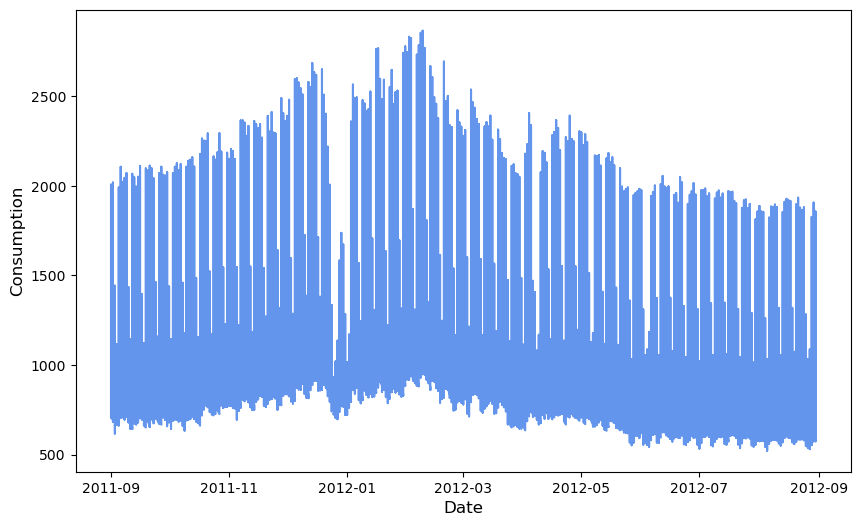

In [14]:
#Plot load against date 
plt.figure(figsize = (10,6))
plt.plot(dftest['Total Parameter'], color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Consumption', size = 12)
plt.show()

#### Augmented Dickey-Fuller Test

In [15]:
#ADF Test
result = adfuller(df['Total Parameter'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  

ADF Statistic: -6.938447732890682
n_lags: 1.0399393488231222e-09
p-value: 1.0399393488231222e-09
Critial Values:
   1%, -3.4307242638530675
Critial Values:
   5%, -2.861705410152796
Critial Values:
   10%, -2.5668580435332715


### Autocorrelation

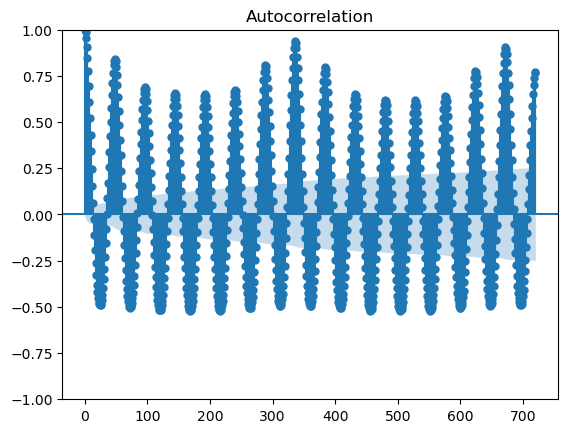

In [16]:
#Plot the acf function
plot_acf(dftest['Total Parameter'],lags=720)
plt.show()

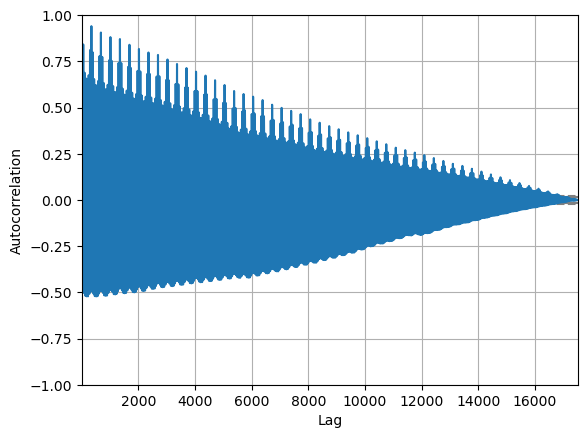

In [17]:
autocorrelation_plot(dftest['Total Parameter'])
plt.show()

### Decomposition

In [18]:
dftest = df.head(1000)

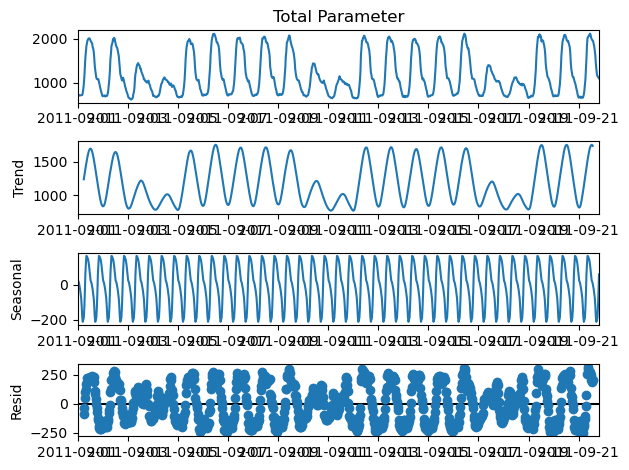

In [19]:
result = seasonal_decompose(dftest['Total Parameter'].dropna(), model='additive', period=24, )
result.plot()
plt.show()

<Axes: xlabel='Date and Time of capture'>

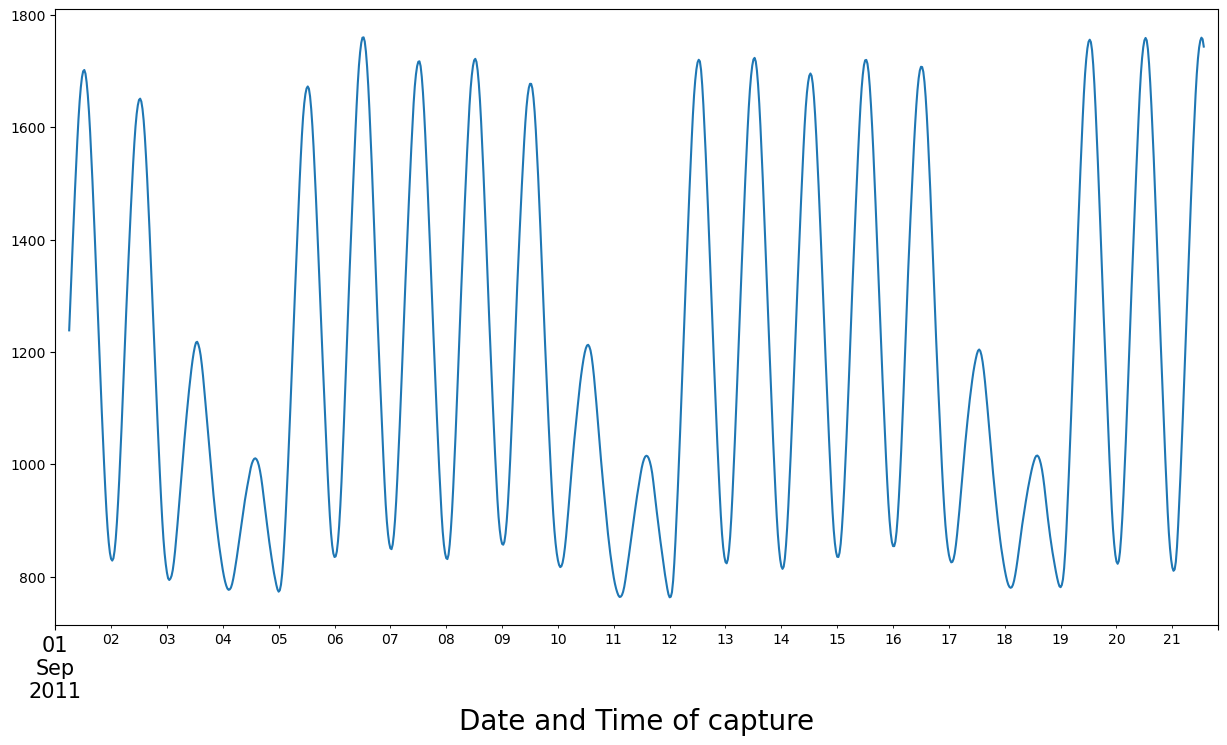

In [20]:
#Plot trend 
fig, (ax1) = plt.subplots(1,1, figsize=(15,8))
plt.xticks(fontsize=15)
plt.xlabel('Date', fontsize=20)
result.trend.plot(ax=ax1)

## Data Split

In [21]:
df

,Total Parameter
Date and Time of capture,
2011-09-01 00:00:00,707.889
2011-09-01 00:30:00,705.840
2011-09-01 01:00:00,724.357
2011-09-01 01:30:00,713.332
2011-09-01 02:00:00,706.644
...,...
2012-08-30 21:30:00,810.731
2012-08-30 22:00:00,764.060
2012-08-30 22:30:00,710.317


In [22]:
#Reset index and create Date column
df = df.reset_index()

In [23]:
#Create prediction data frame with records from last day
dfprediction = df.loc[(df['Date and Time of capture'] == '2012-08-30')]
dfprediction.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 17472 to 17472
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date and Time of capture  1 non-null      datetime64[ns]
 1   Total Parameter           1 non-null      float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 24.0 bytes


In [24]:
#Set Date and Time of capture as index
dfprediction = dfprediction.set_index(['Date and Time of capture'])

In [25]:
#Set Date and Time of capture as index
df = df.set_index(['Date and Time of capture'])

In [26]:
#Split df up between train and test
#Last 6 months for testing
size = int(len(df)*0.73)
train,test=df[0:size],df[size:]
train.head()

,Total Parameter
Date and Time of capture,
2011-09-01 00:00:00,707.889
2011-09-01 00:30:00,705.840
2011-09-01 01:00:00,724.357
2011-09-01 01:30:00,713.332
2011-09-01 02:00:00,706.644


# SARIMA MODEL

### Auto arima model to find optimal parameter values
sarimamodel = auto_arima(train,
                    
                    start_p=0,
                    start_q=0,
                    max_p=2,
                    max_q=2, 
                    m=7,
                    start_P=0,
                    seasonal=True,
                    d=None,
                    D=None,
                    trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)

sarimamodel.summary()

In [27]:
#Run sarima model with optimal parameter values
sarima_model= SARIMAX(train['Total Parameter'], order= (2,1,2), seasonal_order= (2,0,1,7))
results= sarima_model.fit()
print(results.summary())

C:\Users\nanan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
C:\Users\nanan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                     Total Parameter   No. Observations:                12789
Model:             SARIMAX(2, 1, 2)x(2, 0, [1], 7)   Log Likelihood              -66184.793
Date:                             Fri, 01 Sep 2023   AIC                         132385.587
Time:                                     10:34:03   BIC                         132445.237
Sample:                                 09-01-2011   HQIC                        132405.534
                                      - 05-24-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3049      0.055     23.563      0.000       1.196       1.413
ar.L2         -0.4297      

In [28]:
#Obtain the predicted values
predict = pd.DataFrame(results.predict(start=len(test),end=len(df)))
predict.columns = ['predictions']
predict.head()

,predictions
2011-12-08 13:30:00,2403.068527
2011-12-08 14:00:00,2264.564901
2011-12-08 14:30:00,2313.911065
2011-12-08 15:00:00,2294.403888
2011-12-08 15:30:00,2264.498097


In [45]:
#Merge actual values and predicted
final_pred = pd.concat((predict, test), axis=1)
final_pred = final_pred.dropna()

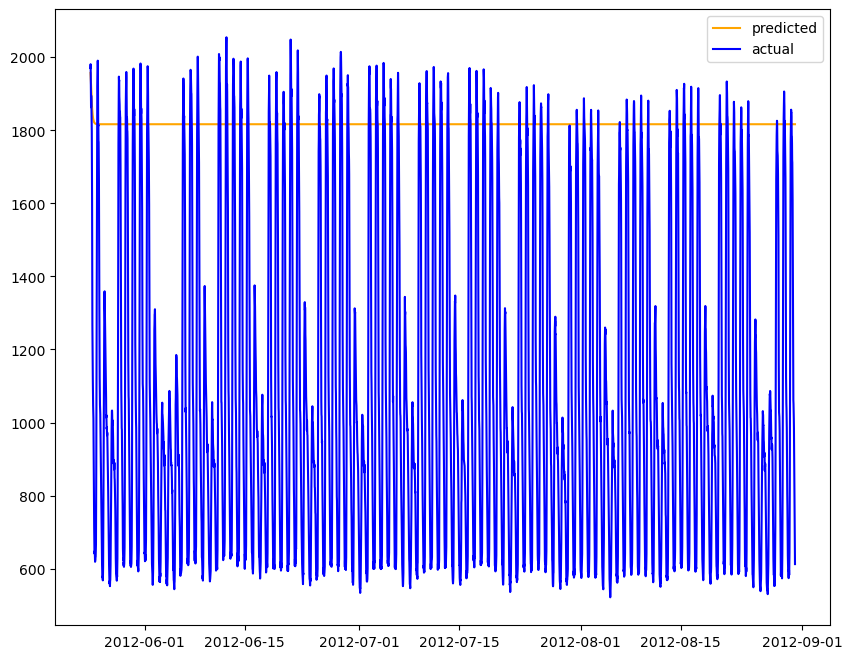

In [46]:
plt.figure(figsize=(10,8))
plt.plot(final_pred.index, final_pred['predictions'],color='orange', label='predicted')
plt.plot(final_pred.index, final_pred['Total Parameter'],color='blue', label='actual')
#plt.plot(pd.DataFrame(results.predict(start=len(dfprediction),end=(dfprediction))),color='red', label='forecast')
plt.legend()

In [40]:
mape_sarima = mean_absolute_percentage_error(final_pred['Total Parameter'],final_pred['predictions'])
print(f"MAPE OF LSTM MODEL : {mape_sarima:.2f} %")

MAPE OF LSTM MODEL : 1.00 %


In [41]:
#Evaluate the model
mse= mean_squared_error(final_pred['Total Parameter'],final_pred['predictions'])
rmse_sarimax= rmse(final_pred['Total Parameter'], final_pred['predictions'])

In [42]:
print(f"Root Mean Square is {rmse_sarimax} \n")
print(f"Mean Square Error is {mse}")

Root Mean Square is 869.5352824389381 

Mean Square Error is 756091.6074061638


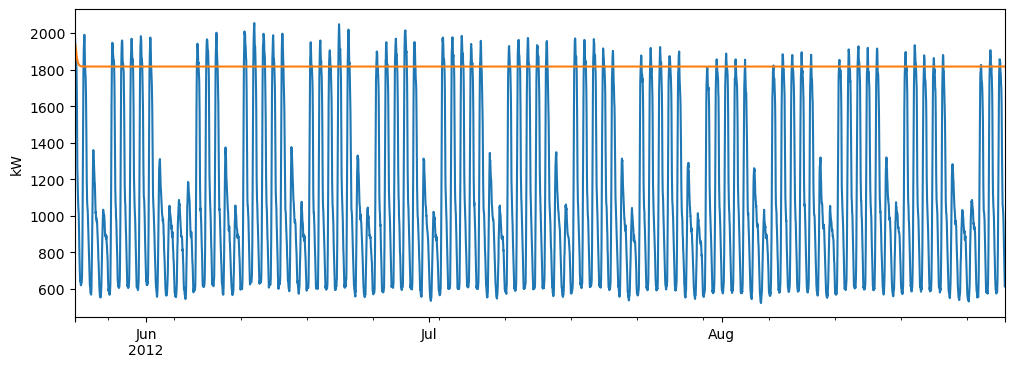

In [43]:
ax = final_pred['Total Parameter'].plot(figsize=(12, 4), color="tab:blue")
_ = final_pred['predictions'].plot(ax=ax, color="tab:orange", ylabel="kW")